# Gap Time Calculations

Get n # of random points in a specific geographic region with associated gap times



## Setup Imports

(not relevant to repo, can skip) 

Adding module path to run correctly in examples folder

In [1]:
import sys
import os

# Add the path to the folder containing the module
module_path = os.path.abspath(os.path.join('..'))
print(module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

/Users/gracekim/Documents/School_Everything_and_LEARNING/Stanford/Githubs/loc-gsopt/src


## Imports

In [2]:
"""
Get n # of random points in a specific geographic region with associated gap times
"""

from common.sat_gen import satellites_from_constellation
from common.station_gen import gs_json,return_bdm_gs
from common.utils import load_earth_data, compute_all_gaps_contacts

from scipy.optimize import minimize
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# Brahe Imports
import brahe as bh
import brahe.data_models as bdm
import brahe.access.access as ba

# random points function
import random_land_points as rlp

## Setup 

In [3]:
############################### SETUP: ###############################

# Make sure to load in earth inertial data every start time!
load_earth_data('data/iau2000A_finals_ab.txt')

############################### STEP 1: Satellites ###############################

# Loading in a satellite constellation 
CONSTELLATIONS = sorted(['YAM', 'UMBRA', 'SKYSAT', 'ICEYE', 'FLOCK', 'HAWK', 'CAPELLA', 'LEGION', 'WORLDVIEW', 'GEOEYE',
                  'NUSAT'])

constellation = CONSTELLATIONS[3]

satellites = satellites_from_constellation(constellation)

############################### STEP 2: Scenario Generation ###############################

# Setting up Epochs
epc0 = bh.Epoch(2024, 5, 20, 0, 0, 0) # This is the epoch of the orbital elements
epc1 = epc0 + 86400 # checking over one day



Loading the latest Earth Orientation Data


# Cost Functions

In [4]:
def cost_func_gap( gs ,satellites = satellites[0:3], epc_start = epc0, epc_end = epc1, plot = False):

    _, _, gaps_seconds = compute_all_gaps_contacts(satellites, [gs],epc_start, epc_end, plot)

    return 3*np.mean(gaps_seconds) + np.std(gaps_seconds)

In [5]:

from global_land_mask import globe

def penalty(lat,long):
    on_water = False
    try:
        on_water = globe.is_ocean(lat,long)
    except:
        on_water = True
    if on_water:
        return 5000
    return 0

def cost_func_gap_penalty(lat,long, gs ,satellites = satellites[0:3], epc_start = epc0, epc_end = epc1, plot = False):

    _, _, gaps_seconds = compute_all_gaps_contacts(satellites, [gs],epc_start, epc_end, plot)

    value = np.mean(gaps_seconds) + penalty(lat,long)

    return value

# Generating 50 Ground Stations and Contacts

In [8]:
import random

lats = []
longs = []
gaps = []

for i in range(100):
    # Latitude: Uniform sampling between -90 and 90 degrees
    lat = -90#random.uniform(-90, 90)
    
    # Longitude: Uniform sampling between -180 and 180 degrees
    lon = random.uniform(-180, 180)
    
    # gs = rlp.random_points('Europe')[0]
    # lon = gs[0]
    # lat = gs[1]

    gs = return_bdm_gs(lon, lat)
    lats.append(lat)
    longs.append(lon)
    print(lat,lon)
    # gap = cost_func_gap( gs ,satellites[0:3], epc0, epc1, False)
    gap = cost_func_gap_penalty(lat,lon,gs ,satellites[0:3], epc0, epc1, False)
    gaps.append(gap)
    print(gap)

-90 161.62501098303903
4722.7249909375
-90 163.3402035246799
4722.7249909375
-90 -103.38677852122294
4722.7249909375
-90 175.57217908271332
4722.7249909375
-90 -110.61909904702729
4722.7249909375
-90 -71.91817819464364
4722.7249909375
-90 -149.21892066988534
4722.7249909375
-90 -16.345278850033594
4722.7249909375
-90 -144.93135673284894
4722.7249909375
-90 100.00305558482461
4722.7249909375
-90 83.87954184238129
4722.7249909375
-90 -8.54396519419305
4722.7249909375
-90 113.04263895580613
4722.7249909375
-90 137.89739976069444
4722.7249909375
-90 -56.62041480038782
4722.7249909375
-90 -130.54490482328376
4722.7249909375
-90 68.41795545730741
4722.7249909375
-90 -124.52641043418018
4722.7249909375
-90 -111.94391482331345
4722.7249909375
-90 -63.85765820709889
4722.7249909375
-90 28.15443287097881
4722.7249909375
-90 30.036865096285624
4722.7249909375
-90 121.6951272544776
4722.7249909375
-90 141.98986902997973
4722.7249909375
-90 -85.33010059126893
4722.7249909375
-90 -176.04058143198466

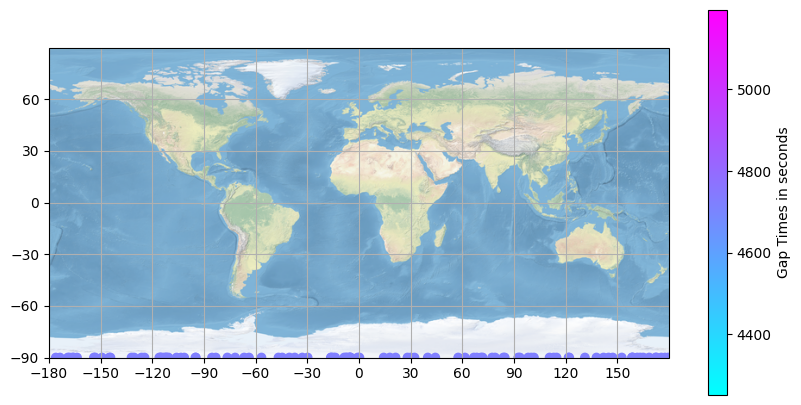

In [9]:
# Plotting Imports

import cartopy.crs as ccrs

# Create the figure
fig = plt.figure(figsize=(10,5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.grid(True)
ax.set_global()
ax.stock_img()
c = 'b' # Set the plot color

ax.set_yticks(np.arange(-90, 90, 30))
ax.set_xticks(np.arange(-180, 180, 30))
sc = ax.scatter(x=longs, y=lats, c=gaps,cmap = 'cool')
cbar = fig.colorbar(sc)
cbar.set_label('Gap Times in seconds')
